# 0. Install and Import Dependencies

In [ ]:
!pip list

In [ ]:
!pip install opencv-python matplotlib imageio gdown

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
# import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
arr = []
with open('dataset.txt', 'r') as file:
    lines = file.readlines()
for line in lines:
    if(len(arr) == 2):
        break
    line = line.split('/')[-1]
    line = "data/s1/" + line
    arr.append(load_video(line).numpy())


In [4]:
np.set_printoptions(threshold=np.inf)
with open("data2.bin", "wb") as file:
    for a in arr:
        a.tofile(file)

In [ ]:
arr = []
with open('dataset.txt', 'r') as file:
    lines = file.readlines()
for line in lines:
    if(len(arr) == 50):
        break
    line = line.split('/')[-1]
    line = "data/s1/" + line
    arr.append(load_video(line).numpy())
np.set_printoptions(threshold=np.inf)
# with open("data50.bin", "wb") as file:
#     for a in arr:
#         a.tofile(file)

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [7]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [9]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
path = "data/alignments/s1/bbaf2n.align"
with open(path, 'r') as f:
    lines = f.read().splitlines()
tokens = []
# print(lines)
for line in lines:
    line = line.split()
    if line[2] != 'sil': 
        tokens = [*tokens,' ',line[2]]
    # print(tokens)
ans = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
print(ans)
print(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))

tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23], shape=(21,), dtype=int64)
tf.Tensor(
[b' ' b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f'
 b' ' b't' b'w' b'o' b' ' b'n' b'o' b'w'], shape=(22,), dtype=string)


In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]


'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

(75, 46, 140, 1)


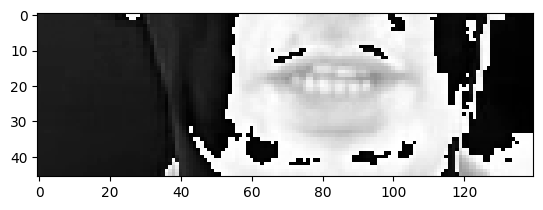

In [16]:
plt.imshow(frames[40], cmap = "gray")
print(frames.shape)
# print(frames[40])

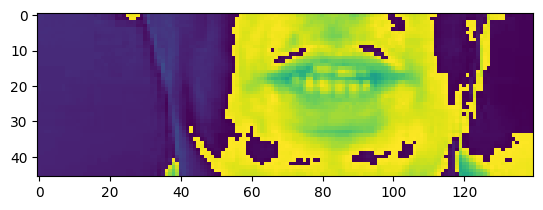

In [17]:
frm = frames[40].numpy()
# cv2.imshow("frame", frm)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(frm)
plt.imshow(frm)

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [21]:
print(char_to_num.vocabulary_size())
print(len("444iiiiiiiiiiiiiimmmmmmmmmmmmmmmmmmmmmmiiiiiiiiiiimmmmmmmmiiiiiiiiiiixxxxxx"))

40
75


# 2. Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.2973201 ],
          [1.2973201 ],
          [1.2973201 ],
          ...,
          [0.07413258],
          [0.03706629],
          [0.03706629]],

         [[1.2973201 ],
          [1.2973201 ],
          [1.2973201 ],
          ...,
          [0.07413258],
          [0.03706629],
          [0.03706629]],

         [[1.2602538 ],
          [1.2602538 ],
          [1.2602538 ],
          ...,
          [0.07413258],
          [0.03706629],
          [0.03706629]],

         ...,

         [[0.85252464],
          [0.85252464],
          [0.85252464],
          ...,
          [9.155373  ],
          [9.155373  ],
          [9.155373  ]],

         [[0.85252464],
          [0.85252464],
          [0.85252464],
          ...,
          [8.970041  ],
          [9.155373  ],
          [9.229506  ]],

         [[0.85252464],
          [0.85252464],
          [0.85252464],
          ...,
          [9.118307  ],
          [9.229506  ],
          [9.229506  ]]],


        [[[1.2231

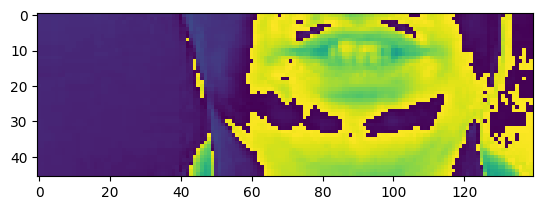

In [29]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [57]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white with s seven again'>

# 3. Design the Deep Neural Network

In [58]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [59]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [60]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))
# model.add(Flatten())

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(41, kernel_initializer='he_normal', activation='softmax'))
# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

In [32]:
yhat = model.predict(val[0])

NameError: name 'model' is not defined

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [5]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [9]:
model.load_weights('models/checkpoint')

In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy

import string

# Define vocabulary
vocab = list("@abcdefghijklmnopqrstuvwxyz'?!123456789  ")

# Create char_to_num and num_to_char dictionaries
char_to_num = {char: num for num, char in enumerate(vocab)}
num_to_char = {num: char for num, char in enumerate(vocab)}

# Test the conversion
print(f"The vocabulary is: {vocab} (size = {len(vocab)})")

# Example usage
input_string = "hello?"
encoded = [char_to_num[char] for char in input_string]
decoded = ''.join([num_to_char[num] for num in encoded])

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")




class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv3d(1, 128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv3 = nn.Conv3d(256, 75, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.flatten = nn.Flatten(start_dim=2)
        self.bidirectional_lstm1 = nn.LSTM(6375, 128, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.bidirectional_lstm2 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.dense = nn.Linear(256, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.flatten(x)
        x, _ = self.bidirectional_lstm1(x)
        x = self.dropout1(x)
        x, _ = self.bidirectional_lstm2(x)
        x = self.dropout2(x)
        x = F.softmax(self.dense(x), dim = 1)
        return x

frames = 75
rows = 46
columns = 140
channels = 1
random_input = torch.randn(1, channels, frames, rows, columns)
Model = MyModel()
output = Model(random_input)
output = torch.squeeze(output).argmax(dim = 1)
print(output)

The vocabulary is: ['@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', ' '] (size = 41)
Encoded: [8, 5, 12, 12, 15, 28]
Decoded: hello?
tensor([34, 39, 34, 34,  2,  8,  2, 17, 20, 13, 22, 32, 13, 21, 40, 31,  9,  8,
        38, 29, 31, 28,  6, 11, 39, 39,  6,  6, 25,  5,  6, 15, 18, 19, 39, 27,
         2, 18, 34, 21, 25,  0, 12,  0, 15, 29, 27, 16,  0,  0, 12, 13,  8, 32,
        23, 16,  3, 27, 31, 16, 39, 12,  0,  9, 39, 25,  1, 22, 21,  7, 22, 23,
        23, 17,  9])


In [8]:
layers = model.layers
tfw = []
# Get the weights for each layer
for layer in layers:
    if hasattr(layer, 'get_weights'):
        weights = layer.get_weights()
        for i, weight_matrix in enumerate(weights):
            print(f"Layer {layer.name}, Weight Matrix {i + 1}:")
            print(weight_matrix.shape)
            tfw.append(weight_matrix)
for ia in tfw:
    print(ia.shape)

Layer conv3d, Weight Matrix 1:
(3, 3, 3, 1, 128)
Layer conv3d, Weight Matrix 2:
(128,)
Layer conv3d_1, Weight Matrix 1:
(3, 3, 3, 128, 256)
Layer conv3d_1, Weight Matrix 2:
(256,)
Layer conv3d_2, Weight Matrix 1:
(3, 3, 3, 256, 75)
Layer conv3d_2, Weight Matrix 2:
(75,)
Layer bidirectional, Weight Matrix 1:
(6375, 512)
Layer bidirectional, Weight Matrix 2:
(128, 512)
Layer bidirectional, Weight Matrix 3:
(512,)
Layer bidirectional, Weight Matrix 4:
(6375, 512)
Layer bidirectional, Weight Matrix 5:
(128, 512)
Layer bidirectional, Weight Matrix 6:
(512,)
Layer bidirectional_1, Weight Matrix 1:
(256, 512)
Layer bidirectional_1, Weight Matrix 2:
(128, 512)
Layer bidirectional_1, Weight Matrix 3:
(512,)
Layer bidirectional_1, Weight Matrix 4:
(256, 512)
Layer bidirectional_1, Weight Matrix 5:
(128, 512)
Layer bidirectional_1, Weight Matrix 6:
(512,)
Layer dense, Weight Matrix 1:
(256, 41)
Layer dense, Weight Matrix 2:
(41,)
(3, 3, 3, 1, 128)
(128,)
(3, 3, 3, 128, 256)
(256,)
(3, 3, 3, 256, 

In [28]:
print(type(tfw[0]))

<class 'numpy.ndarray'>


In [9]:
Model.bidirectional_lstm1.weight_ih_l0.data = torch.tensor(tfw[6]).permute(1, 0)
Model.bidirectional_lstm1.weight_hh_l0.data = torch.tensor(tfw[7]).permute(1, 0)
Model.bidirectional_lstm1.bias_ih_l0.data = torch.tensor(tfw[8])
Model.bidirectional_lstm1.bias_hh_l0.data = torch.tensor(tfw[8])
Model.bidirectional_lstm1.weight_ih_l0_reverse.data = torch.tensor(tfw[9]).permute(1, 0)
Model.bidirectional_lstm1.weight_hh_l0_reverse.data = torch.tensor(tfw[10]).permute(1, 0)
Model.bidirectional_lstm1.bias_ih_l0_reverse.data = torch.tensor(tfw[11])
Model.bidirectional_lstm1.bias_hh_l0_reverse.data = torch.tensor(tfw[11])
Model.bidirectional_lstm2.weight_ih_l0.data = torch.tensor(tfw[12]).permute(1, 0)
Model.bidirectional_lstm2.weight_hh_l0.data = torch.tensor(tfw[13]).permute(1, 0)
Model.bidirectional_lstm2.bias_ih_l0.data = torch.tensor(tfw[14])
Model.bidirectional_lstm2.bias_hh_l0.data = torch.tensor(tfw[14])
Model.bidirectional_lstm2.weight_ih_l0_reverse.data = torch.tensor(tfw[15]).permute(1, 0)
Model.bidirectional_lstm2.weight_hh_l0_reverse.data = torch.tensor(tfw[16]).permute(1, 0)
Model.bidirectional_lstm2.bias_ih_l0_reverse.data = torch.tensor(tfw[17])
Model.bidirectional_lstm2.bias_hh_l0_reverse.data = torch.tensor(tfw[17])
c1 = torch.tensor(tfw[0]).permute(4, 3, 0, 1, 2)
c1b = torch.tensor(tfw[1])
c2 = torch.tensor(tfw[2]).permute(4, 3, 0, 1, 2)
c2b = torch.tensor(tfw[3])
c3 = torch.tensor(tfw[4]).permute(4, 3, 0, 1, 2)
c3b = torch.tensor(tfw[5])
Model.conv1.weight.data = c1
Model.conv1.bias.data = c1b
Model.conv2.weight.data = c2
Model.conv2.bias.data = c2b
Model.conv3.bias.data = c3
Model.conv3.bias.data = c3b
Model.dense.weight.data = torch.tensor(tfw[18]).permute(1, 0)
Model.dense.bias.data = torch.tensor(tfw[19])

In [33]:
frm = torch.tensor(frames).unsqueeze(0)
frm.shape

torch.Size([1])

In [10]:
torch.save(Model.state_dict(), 'model.pth')

In [38]:
frm = torch.tensor(val[0])
frm.shape

torch.Size([2, 75, 46, 140, 1])

In [31]:
for name, param in Model.named_parameters():
    print(name, param)

conv1.weight Parameter containing:
tensor([[[[[ 3.3403e-02,  1.8693e-02, -3.1052e-02],
           [-2.0454e-02,  3.8681e-02, -2.6088e-02],
           [-3.6107e-02, -3.4217e-02,  3.9526e-03]],

          [[ 3.7000e-02, -1.8949e-02, -3.8159e-02],
           [-2.0148e-02,  6.1746e-03,  2.3473e-02],
           [-1.9151e-02,  1.1921e-04, -2.4827e-02]],

          [[ 1.5829e-02, -1.6312e-02, -2.5210e-02],
           [-9.4564e-03, -3.2912e-02, -8.6453e-03],
           [-3.1156e-02, -3.2910e-02,  2.1643e-02]]]],



        [[[[-9.5846e-03, -3.0622e-02, -4.3643e-03],
           [-9.7736e-03, -2.6881e-03, -8.3331e-03],
           [ 1.3500e-02,  3.1120e-02,  2.7125e-02]],

          [[-9.5665e-03, -1.3422e-02, -3.1843e-02],
           [-4.8036e-03, -1.7950e-02,  2.8817e-02],
           [ 2.7110e-02, -2.3057e-02, -3.2470e-02]],

          [[-3.4354e-02,  9.2134e-03,  1.7889e-02],
           [-3.9931e-02, -1.5341e-02,  3.5976e-02],
           [-2.6183e-03,  2.8577e-02,  4.1138e-02]]]],



        [

In [32]:
print(tfw)

[array([[[[[ 3.34028527e-02, -9.58457217e-03, -2.27138679e-02, ...,
           -1.48947295e-02, -1.10784583e-02,  1.83072612e-02]],

         [[ 1.86932757e-02, -3.06219794e-02,  8.68196040e-03, ...,
            7.82955065e-03,  1.05958432e-02,  3.66679803e-02]],

         [[-3.10517903e-02, -4.36432287e-03,  3.58481407e-02, ...,
            3.03372517e-02, -3.79147641e-02, -1.28129069e-02]]],


        [[[-2.04541851e-02, -9.77356732e-03, -1.06616896e-02, ...,
           -9.54235718e-03,  3.74539942e-03, -3.36397290e-02]],

         [[ 3.86807472e-02, -2.68808007e-03, -2.49911565e-02, ...,
           -2.95022093e-02,  1.87399425e-02,  2.31632814e-02]],

         [[-2.60879956e-02, -8.33309442e-03, -3.19488607e-02, ...,
            2.58300826e-02, -3.34991328e-02,  3.05552036e-03]]],


        [[[-3.61070484e-02,  1.35004893e-02,  3.68807018e-02, ...,
            1.86220594e-02, -1.17802508e-02, -3.84591520e-03]],

         [[-3.42168845e-02,  3.11197266e-02, -3.15332562e-02, ...,
    

In [64]:
val1 = torch.tensor(val[0])

In [68]:
for name, param in Model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([128, 1, 3, 3, 3])
conv1.bias torch.Size([128])
conv2.weight torch.Size([256, 128, 3, 3, 3])
conv2.bias torch.Size([256])
conv3.weight torch.Size([75, 256, 3, 3, 3])
conv3.bias torch.Size([75])
bidirectional_lstm1.weight_ih_l0 torch.Size([512, 6375])
bidirectional_lstm1.weight_hh_l0 torch.Size([512, 128])
bidirectional_lstm1.bias_ih_l0 torch.Size([512])
bidirectional_lstm1.bias_hh_l0 torch.Size([512])
bidirectional_lstm1.weight_ih_l0_reverse torch.Size([512, 6375])
bidirectional_lstm1.weight_hh_l0_reverse torch.Size([512, 128])
bidirectional_lstm1.bias_ih_l0_reverse torch.Size([512])
bidirectional_lstm1.bias_hh_l0_reverse torch.Size([512])
bidirectional_lstm2.weight_ih_l0 torch.Size([512, 256])
bidirectional_lstm2.weight_hh_l0 torch.Size([512, 128])
bidirectional_lstm2.bias_ih_l0 torch.Size([512])
bidirectional_lstm2.bias_hh_l0 torch.Size([512])
bidirectional_lstm2.weight_ih_l0_reverse torch.Size([512, 256])
bidirectional_lstm2.weight_hh_l0_reverse torch.Size([5

In [31]:
Model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [39]:
val1 = frm
val1 = val1.permute(0, 4, 1, 2, 3)
output = Model(val1)
output = torch.squeeze(output[0]).argmax(dim = 1)
output = output.tolist()
print(len(output))
s = ""
for i in output:
    s += num_to_char[i]
print(s)

75
cpcpc eddu!tsb74t7jgbp8!4!!mcpbr@ dy? 8erbznda2fpxz6 himyqwc1fi5yvxm2 l myr


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]